In [21]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/Packages'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)
!pip install --target=$nb_path bio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached bio-1.3.2-py3-none-any.whl (272 kB)
  Using cached mygene-3.2.2-py2.py3-none-any.whl (5.4 kB)
  Using cached biopython-1.79-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (2.3 MB)
     |████████████████████████████████| 76 kB 3.3 MB/s 
     |████████████████████████████████| 62 kB 790 kB/s 
     |████████████████████████████████| 15.7 MB 56 kB/s 
  Using cached biothings_client-0.2.6-py2.py3-none-any.whl (37 kB)
     |████████████████████████████████| 61 kB 7.2 MB/s 
     |████████████████████████████████| 138 kB 44.4 MB/s 
     |████████████████████████████████| 149 kB 71.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is in

In [22]:
!pip install bio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Linear, ReLU, Sequential, Conv2d, Conv1d, MaxPool1d, MaxPool2d, BatchNorm1d, BatchNorm2d, Dropout
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm, trange
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, normalize
import os, glob
%matplotlib inline

In [23]:
torch.manual_seed(123)
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [25]:
data_path = "drive/MyDrive/Datasets/CS582/topic1-data"
batch_size = 100
validation_ratio = 0.2

In [26]:
tf_path = data_path + "/BATF"
train_data_path = tf_path + "/BATF-train-sequence.fa"
test_data_path = tf_path + "/BATF-test-sequence.fa"
train_label_path = tf_path + "/BATF-train.bed"
test_label_path = tf_path + "/BATF-test.bed"

In [27]:
def get_pwm_list(non_site_prob):
  pwm_files = glob.glob(tf_path + "/*.wtmx")
  pwm_count = len(pwm_files)
  pwm_list = [normalize(pd.read_csv(pwm_file, names = ['A', 'C', 'G', 'T'], sep="\t", header=None,
                          skiprows=1, skipfooter=1, dtype='float32', engine='python').to_numpy(), axis=1, norm='l1') for pwm_file in pwm_files]
  print(pwm_list)
  length = np.array([pwm.shape[0] for pwm in pwm_list])
  max_length = length.max()
  append = max_length - length
  append_up = append // 2
  append_down = append - append_up
  arr_up = np.array([np.repeat([non_site_prob], append_up[i], axis=0) for i in range(pwm_count)])
  arr_down = np.array([np.repeat([non_site_prob], append_down[i], axis=0) for i in range(pwm_count)])
  pwm_list = np.array([np.concatenate((arr_up[i], pwm_list[i], arr_down[i]), axis=0).reshape(1, max_length, 4).astype('float32') for i in range(pwm_count)])
  #print('pwm_list', pwm_list)
  #print(pwm_list[0].shape)
  return pwm_list

In [28]:
def get_tf_list(data_path):
  tf_list = os.listdir(data_path)
  for tf in tf_list:
      if not os.path.isdir(data_path+tf):
          tf_list.remove(tf)
  return tf_list

In [29]:
def one_hot_encoder(sequence):
   encoder = OneHotEncoder(sparse=False, dtype=int)
   encoder.fit([['A'], ['C'], ['G'], ['T']])
   onehot_encoded = encoder.transform(sequence)
   return onehot_encoded

In [30]:
class TFBindingDataset(Dataset):
    def __init__(self, data_path, label_path, train):
        super(TFBindingDataset, self).__init__()
        self.X = [np.array(list(record.seq.__str__().upper())).reshape(-1, 1) for record in SeqIO.parse(data_path, "fasta")]
        self.X = np.array([one_hot_encoder(data) for data in self.X]).astype('float32')
        shape = self.X.shape
        self.init_kernel=None
        if train:
          non_site_prob = np.sum(np.sum(self.X, axis=1), axis=0)/(shape[0]*shape[1])
          self.init_kernel = torch.as_tensor(get_pwm_list(non_site_prob))
          #print(self.init_kernel)
        #print(self.init_kernel)
        self.X = torch.as_tensor(self.X.reshape(shape[0], 1, shape[1], shape[2]))
        self.y = pd.read_csv(label_path, sep='\t', header=None).drop(labels=0, axis=1).to_numpy(dtype=float)

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.X.shape[0]

    def get_init_kernel(self):
        #print(self.init_kernel)
        return self.init_kernel

In [31]:
tf_list = get_tf_list(data_path)

In [32]:
train_set = TFBindingDataset(train_data_path, train_label_path, True)
weight = train_set.get_init_kernel()
#print(weight)
test_set = TFBindingDataset(test_data_path, test_label_path, False)  
train_set, val_set = random_split(train_set, [int(len(train_set)*(1 - validation_ratio)), int(len(train_set)*validation_ratio)])    

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)

[array([[0.7647059 , 0.23529412, 0.        , 0.        ],
       [0.7647059 , 0.        , 0.11764706, 0.11764706],
       [0.        , 0.1764706 , 0.7647059 , 0.05882353],
       [0.11764706, 0.        , 0.        , 0.88235295],
       [0.        , 0.11764706, 0.1764706 , 0.7058824 ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.9411765 , 0.        , 0.        , 0.05882353],
       [0.11764706, 0.47058824, 0.        , 0.4117647 ],
       [0.        , 0.23529412, 0.        , 0.7647059 ],
       [0.11764706, 0.5882353 , 0.        , 0.29411766],
       [0.        , 0.        , 0.        , 1.        ],
       [0.05882353, 0.        , 0.88235295, 0.05882353],
       [1.        , 0.        , 0.        , 0.        ],
       [0.4117647 , 0.3529412 , 0.23529412, 0.        ]], dtype=float32), array([[0.49355668, 0.09504665, 0.23813425, 0.17326242],
       [0.11609922, 0.35912654, 0.2958691 , 0.22890514],
       [0.042

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [33]:
for data in train_loader:
    X, y = data 
    print(X.shape)
    print(y.shape)
    break

torch.Size([100, 1, 501, 4])
torch.Size([100, 1])


In [34]:
def plot_binding_histogram(data_loader, data_name):
    binding_values = []
    for data in data_loader:
        _, y = data
        binding_values.extend(torch.reshape(y, (-1,))) 
    binding_values = torch.stack(binding_values)
    plt.figure(figsize=(7,7))
    plt.title(data_name + " Bindings Histogram")
    plt.xlabel("Binding Value")
    plt.ylabel("Count")
    plt.hist(binding_values, bins=40)

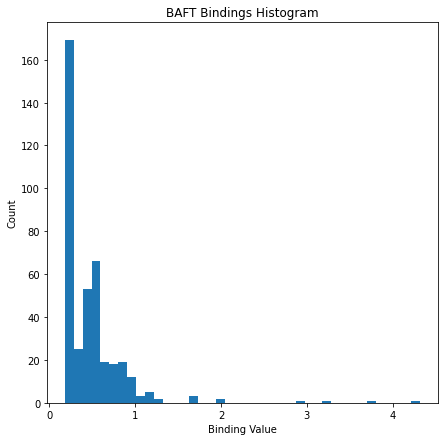

In [35]:
plot_binding_histogram(test_loader, "BAFT")

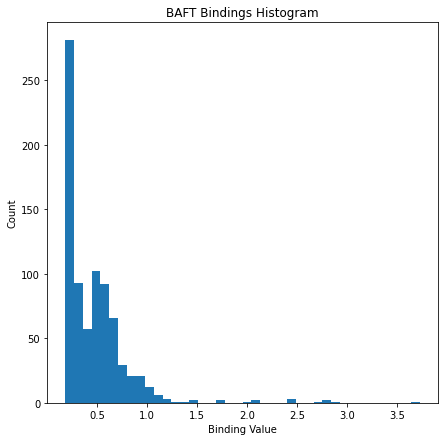

In [36]:
plot_binding_histogram(train_loader, "BAFT")

In [37]:
"""
class BindingPredictionCNN(Module):
    def __init__(self, weight):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=weight.shape[0], kernel_size=(weight.shape[2], 4), stride=1)
        with torch.no_grad():
            self.conv1.weight = nn.Parameter(weight)
        self.conv2 = Conv1d(in_channels=weight.shape[0], out_channels=20, kernel_size=14, stride=1)
        self.conv3 = Conv1d(in_channels=20, out_channels=30, kernel_size=10, stride=1)

        self.bn1 = BatchNorm1d(weight.shape[0])
        self.bn2 = BatchNorm1d(20)
        self.bn3 = BatchNorm1d(30)

        self.fc1 = Linear(in_features=1560, out_features=750)
        #self.fc2 = Linear(in_features=1500, out_features=250)
        self.out = Linear(in_features=750, out_features=1)

    def forward(self, x):
        x = self.bn1(F.relu(F.max_pool1d((self.conv1(x)).squeeze(), 2, 2)))
        x = self.bn2(F.relu(F.max_pool1d((self.conv2(x)), 2, 2)))
        x = self.bn3(F.relu(F.max_pool1d((self.conv3(x)), 2, 2)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.out(x)
        return x
"""

'\nclass BindingPredictionCNN(Module):\n    def __init__(self, weight):\n        super().__init__()\n        self.conv1 = Conv2d(in_channels=1, out_channels=weight.shape[0], kernel_size=(weight.shape[2], 4), stride=1)\n        with torch.no_grad():\n            self.conv1.weight = nn.Parameter(weight)\n        self.conv2 = Conv1d(in_channels=weight.shape[0], out_channels=20, kernel_size=14, stride=1)\n        self.conv3 = Conv1d(in_channels=20, out_channels=30, kernel_size=10, stride=1)\n\n        self.bn1 = BatchNorm1d(weight.shape[0])\n        self.bn2 = BatchNorm1d(20)\n        self.bn3 = BatchNorm1d(30)\n\n        self.fc1 = Linear(in_features=1560, out_features=750)\n        #self.fc2 = Linear(in_features=1500, out_features=250)\n        self.out = Linear(in_features=750, out_features=1)\n\n    def forward(self, x):\n        x = self.bn1(F.relu(F.max_pool1d((self.conv1(x)).squeeze(), 2, 2)))\n        x = self.bn2(F.relu(F.max_pool1d((self.conv2(x)), 2, 2)))\n        x = self.bn3(F

In [68]:
class BindingPredictionCNN(Module):
    def __init__(self, weight):
        super().__init__()
        #print(weight)
        self.conv1 = Conv2d(in_channels=1, out_channels=weight.shape[0], kernel_size=(weight.shape[2], 4), stride=1, bias=False)
        #with torch.no_grad():
            #self.conv1.weight = nn.Parameter(weight)
        self.conv2 = Conv1d(in_channels=weight.shape[0], out_channels=20, kernel_size=15, stride=1)
        self.conv3 = Conv1d(in_channels=20, out_channels=30, kernel_size=10, stride=1)

        self.bn1 = BatchNorm1d(weight.shape[0])
        self.bn2 = BatchNorm1d(20)
        self.bn3 = BatchNorm1d(30)

        self.fc1 = Linear(in_features=1560, out_features=750)
        self.fc2 = Linear(in_features=750, out_features=350)
        self.out = Linear(in_features=350, out_features=1)

        self.drop1 = Dropout(0)
        self.drop2 = Dropout(0)
        self.drop3 = Dropout(0)
        self.drop4 = Dropout(0)
        self.drop5 = Dropout(0)

    def forward(self, x):
        x = self.drop1(self.bn1(F.relu(F.max_pool1d((self.conv1(x)).squeeze(), 2, 2))))
        x = self.drop2(self.bn2(F.relu(F.max_pool1d((self.conv2(x)), 2, 2))))
        x = self.drop3(self.bn3(F.relu(F.max_pool1d((self.conv3(x)), 2, 2))))
        #x = F.relu(F.max_pool1d((self.conv3(x)), 2, 2))

        x = x.view(x.size(0), -1)
        x = self.drop4(F.relu(self.fc1(x)))
        x = self.drop5(F.relu(self.fc2(x)))
        x = self.out(x)
        return x

In [69]:
model = BindingPredictionCNN(weight)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#print(model)

In [65]:
def plot_loss(train_log, val_log, epoch_num):
    plt.figure(figsize=(7,7))
    plt.plot(range(1, epoch_num + 1), train_log, color='C0', label='training')
    plt.plot(range(1, epoch_num + 1), val_log, color='C1', label='validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('MSE Loss')
    plt.legend(loc='best')
    plt.show()

In [70]:
def train(net, train_loader, val_loader, optimizer, criterion, epoch_num=200):
    train_log = []
    val_log = []

    lambda1 = 0.00005
    lambda2 = 0.000005

    for epoch in range(1, epoch_num+1):
        train_loss = []
        net.train()
        for (x, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):        
            x, y = x.to(device), y.to(device)        
            optimizer.zero_grad()
            outputs = net(x)
            loss = criterion(outputs.float(), y.float())
            params = []
            for param in net.parameters():
              params.append(param.view(-1))
            params = torch.cat(params)
            l1_loss = lambda1 * torch.abs(params).sum()
            l2_loss = lambda2 * torch.square(params).sum()
            loss += l1_loss + l2_loss
            loss.backward()                
            optimizer.step()        
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))
        print('============ epoch %d =============' %epoch)
        print('train loss: %.3f' % np.mean(train_loss), flush=True, end='')

        test_loss = []
        net.eval()
        with torch.no_grad():                
            for (x, y) in tqdm(val_loader, desc='Validation ', leave=False):         
                x, y = x.to(device), y.to(device)        
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())            
                test_loss.append(loss.item())
        val_log.append(np.mean(test_loss)) 
        print('validation loss: %.3f' % np.mean(test_loss), flush=True, end='')
    return train_log, val_log

In [71]:
train_log, val_log = train(model, train_loader, val_loader, optimizer, criterion)

Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 1 =============
train loss: 1.202

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.220

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 2 =============
train loss: 1.020

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.118

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 3 =============
train loss: 0.890

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.131

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 4 =============
train loss: 0.792

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.103

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 5 =============
train loss: 0.696

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 6 =============
train loss: 0.604

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.108

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 7 =============
train loss: 0.514

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 8 =============
train loss: 0.439

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 9 =============
train loss: 0.372

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 10 =============
train loss: 0.322

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 11 =============
train loss: 0.279

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.119

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 12 =============
train loss: 0.256

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 13 =============
train loss: 0.236

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.127

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 14 =============
train loss: 0.246

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 15 =============
train loss: 0.220

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.125

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 16 =============
train loss: 0.231

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 17 =============
train loss: 0.192

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 18 =============
train loss: 0.180

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.108

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 19 =============
train loss: 0.157

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 20 =============
train loss: 0.152

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.107

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 21 =============
train loss: 0.134

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.120

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 22 =============
train loss: 0.137

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 23 =============
train loss: 0.121

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 24 =============
train loss: 0.121

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 25 =============
train loss: 0.105

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 26 =============
train loss: 0.099

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 27 =============
train loss: 0.089

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 28 =============
train loss: 0.085

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 29 =============
train loss: 0.080

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 30 =============
train loss: 0.079

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 31 =============
train loss: 0.075

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 32 =============
train loss: 0.078

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 33 =============
train loss: 0.073

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 34 =============
train loss: 0.078

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 35 =============
train loss: 0.071

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 36 =============
train loss: 0.074

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 37 =============
train loss: 0.066

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 38 =============
train loss: 0.066

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 39 =============
train loss: 0.058

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 40 =============
train loss: 0.057

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 41 =============
train loss: 0.052

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 42 =============
train loss: 0.050

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 43 =============
train loss: 0.047

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 44 =============
train loss: 0.047

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 45 =============
train loss: 0.045

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 46 =============
train loss: 0.046

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 47 =============
train loss: 0.046

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 48 =============
train loss: 0.049

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 49 =============
train loss: 0.047

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 50 =============
train loss: 0.053

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.108

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 51 =============
train loss: 0.050

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 52 =============
train loss: 0.051

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 53 =============
train loss: 0.044

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 54 =============
train loss: 0.044

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 55 =============
train loss: 0.040

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 56 =============
train loss: 0.040

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 57 =============
train loss: 0.038

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 58 =============
train loss: 0.037

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 59 =============
train loss: 0.036

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 60 =============
train loss: 0.034

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 61 =============
train loss: 0.033

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 62 =============
train loss: 0.032

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 63 =============
train loss: 0.032

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 64 =============
train loss: 0.031

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 65 =============
train loss: 0.031

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 66 =============
train loss: 0.031

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 67 =============
train loss: 0.031

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 68 =============
train loss: 0.032

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 69 =============
train loss: 0.035

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 70 =============
train loss: 0.035

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 71 =============
train loss: 0.043

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 72 =============
train loss: 0.037

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.118

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 73 =============
train loss: 0.042

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 74 =============
train loss: 0.037

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 75 =============
train loss: 0.040

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 76 =============
train loss: 0.033

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 77 =============
train loss: 0.031

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 78 =============
train loss: 0.030

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 79 =============
train loss: 0.029

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 80 =============
train loss: 0.029

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 81 =============
train loss: 0.028

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 82 =============
train loss: 0.027

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 83 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 84 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 85 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 86 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 87 =============
train loss: 0.025

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 88 =============
train loss: 0.025

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 89 =============
train loss: 0.025

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 90 =============
train loss: 0.025

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 91 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 92 =============
train loss: 0.025

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 93 =============
train loss: 0.025

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 94 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 95 =============
train loss: 0.027

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.119

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 96 =============
train loss: 0.030

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 97 =============
train loss: 0.028

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.118

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 98 =============
train loss: 0.035

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 99 =============
train loss: 0.031

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 100 =============
train loss: 0.038

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 101:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 101 =============
train loss: 0.031

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 102:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 102 =============
train loss: 0.033

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 103:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 103 =============
train loss: 0.030

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 104:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 104 =============
train loss: 0.028

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 105:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 105 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 106:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 106 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 107:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 107 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 108:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 108 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 109:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 109 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 110:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 110 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 111:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 111 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 112:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 112 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 113:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 113 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 114:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 114 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 115:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 115 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 116:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 116 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 117:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 117 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 118:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 118 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 119:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 119 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 120:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 120 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 121:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 121 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 122:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 122 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 123:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 123 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.118

Training epoch 124:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 124 =============
train loss: 0.029

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 125:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 125 =============
train loss: 0.028

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 126:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 126 =============
train loss: 0.034

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 127:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 127 =============
train loss: 0.033

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.119

Training epoch 128:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 128 =============
train loss: 0.044

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 129:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 129 =============
train loss: 0.031

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 130:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 130 =============
train loss: 0.032

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 131:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 131 =============
train loss: 0.028

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 132:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 132 =============
train loss: 0.029

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 133:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 133 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 134:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 134 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 135:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 135 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 136:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 136 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 137:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 137 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 138:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 138 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 139:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 139 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 140:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 140 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 141:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 141 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 142:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 142 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 143:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 143 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 144:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 144 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 145:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 145 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 146:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 146 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 147:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 147 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 148:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 148 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 149:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 149 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 150:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 150 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 151:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 151 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 152:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 152 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 153:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 153 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 154:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 154 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 155:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 155 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 156:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 156 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 157:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 157 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 158:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 158 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.117

Training epoch 159:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 159 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 160:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 160 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 161:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 161 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 162:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 162 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 163:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 163 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.114

Training epoch 164:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 164 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.116

Training epoch 165:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 165 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.115

Training epoch 166:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 166 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.120

Training epoch 167:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 167 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.120

Training epoch 168:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 168 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.122

Training epoch 169:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 169 =============
train loss: 0.027

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.118

Training epoch 170:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 170 =============
train loss: 0.027

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.120

Training epoch 171:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 171 =============
train loss: 0.035

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 172:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 172 =============
train loss: 0.029

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 173:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 173 =============
train loss: 0.035

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.107

Training epoch 174:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 174 =============
train loss: 0.025

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 175:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 175 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 176:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 176 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 177:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 177 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 178:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 178 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 179:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 179 =============
train loss: 0.022

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 180:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 180 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 181:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 181 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 182:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 182 =============
train loss: 0.020

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 183:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 183 =============
train loss: 0.020

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 184:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 184 =============
train loss: 0.020

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 185:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 185 =============
train loss: 0.019

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.111

Training epoch 186:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 186 =============
train loss: 0.019

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 187:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 187 =============
train loss: 0.019

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 188:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 188 =============
train loss: 0.019

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 189:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 189 =============
train loss: 0.019

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 190:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 190 =============
train loss: 0.019

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 191:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 191 =============
train loss: 0.019

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 192:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 192 =============
train loss: 0.019

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 193:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 193 =============
train loss: 0.019

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 194:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 194 =============
train loss: 0.020

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 195:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 195 =============
train loss: 0.021

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.113

Training epoch 196:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 196 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.109

Training epoch 197:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 197 =============
train loss: 0.024

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 198:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 198 =============
train loss: 0.030

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

Training epoch 199:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 199 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.112

Training epoch 200:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 200 =============
train loss: 0.032

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.110

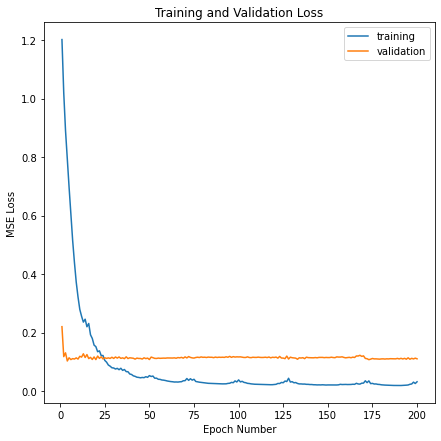

In [72]:
plot_loss(train_log, val_log, 200)

In [ ]:
def test(net, test_loader):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():                
        for (x_input,labels) in tqdm(test_loader, desc='Test ', leave=False):         
            x_input, labels = x_input.to(device), labels.to(device)        
            outputs = net(x_input)
            y_true.extend(labels.float().detach().cpu().numpy())
            y_pred.extend(outputs.float().detach().cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

In [ ]:
y_true, y_pred = test(model, test_loader)

In [ ]:
print("Test MSE: ", mean_squared_error(y_true, y_pred))

# Classification

In [ ]:
binding_threshold = np.median(binding_values)

In [ ]:
binding_values = []
for data in train_loader:
    _, y = data
    binding_values.extend(torch.reshape(y, (-1,))) 
for data in val_loader:
    _, y = data
    binding_values.extend(torch.reshape(y, (-1,))) 
binding_values = torch.stack(binding_values)

In [ ]:
binding_threshold

In [ ]:
y_pred_binary = (y_pred > binding_threshold) * 1
y_true_binary = (y_true > binding_threshold) * 1

In [ ]:
def classification_statistics(y_true_binary, y_pred_binary):
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)

    print(confusion_matrix(y_true_binary, y_pred_binary))
    print(classification_report(y_true_binary, y_pred_binary))
    print("=== Statistics ===")
    print("Test Accuracy: %.3f" % accuracy)
    print("Test Sensitivity: %.3f" % sensitivity)
    print("Test Specificity: %.3f" % specificity)
    print("Test F1-Score: %.3f" % f1_score)

In [ ]:
classification_statistics(y_true_binary, y_pred_binary)

In [ ]:
fpr, tpr, _ = roc_curve(y_true_binary,  y_pred_binary)
auc = roc_auc_score(y_true_binary, y_pred_binary)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend()
plt.show()